In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [4]:
wr=1

In [5]:
names_wrs = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

In [6]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

In [7]:
from scipy.stats import theilslopes
import statsmodels.api as sm

In [8]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [9]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2337241071.py:16: FutureWarning: A value

In [10]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        # df_temp = df_temp[(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

In [11]:
wr=1
# Plot metrics
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])
df_events_temp = copy.deepcopy(dic_dfs_durations['ERA5'][f'wr{wr}'])
is_leap_year = df_events_temp.index.is_leap_year
total_days_in_year = np.where(is_leap_year, 366, 365)

# Convert DatetimeIndex to years in decimals
df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values

years = df_stats_temp.index
yearly_count = df_events_temp.groupby('year').sum()['duration']
yearly_count = yearly_count.reindex(index=np.arange(1948,2024))

In [12]:
yearly_freq = 100*yearly_count/(365/2)

In [13]:
yearly_freq = yearly_freq.fillna(0)

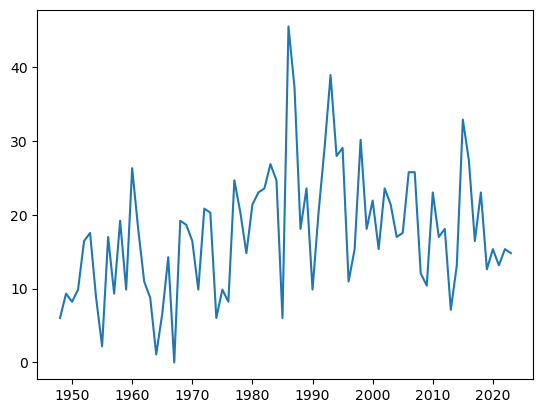

In [14]:
plt.plot(yearly_freq)

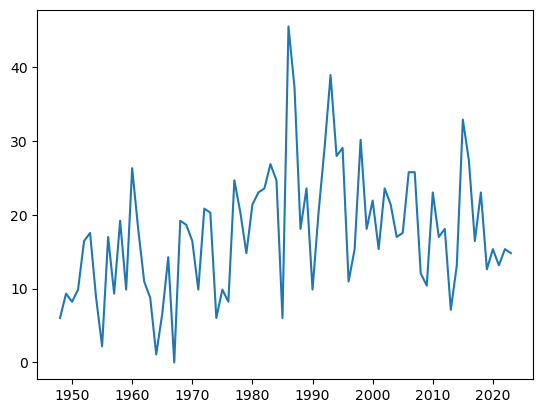

In [15]:
plt.plot(yearly_freq)

In [16]:
# yearly_freq.to_csv('PT_yearly_freq.csv')

# pdo

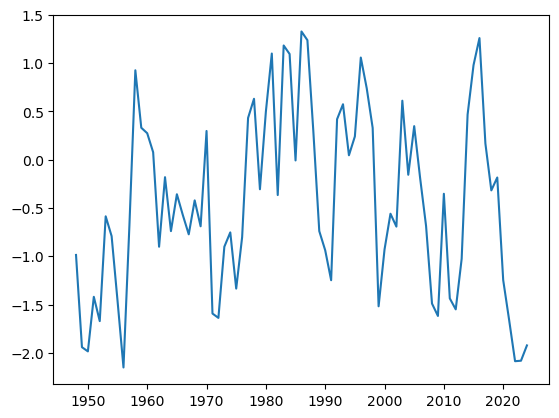

In [17]:
def read_pdo_csv(csv_string_or_filepath):
    """
    Reads a CSV string or file with the specified format into a Pandas DataFrame.

    Args:
        csv_string_or_filepath (str): The CSV string or the path to the CSV file.

    Returns:
        pd.DataFrame: The Pandas DataFrame containing the data.
    """
    try:
        # Try to read from a file path
        with open(csv_string_or_filepath, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        # Try to read from a string
        lines = csv_string_or_filepath.splitlines()

    # Skip the first line (header)
    data_lines = lines[1:]

    # Process the data
    data = []
    for line in data_lines:
        values = line.split()
        data.append(values)

    # Create the DataFrame
    df = pd.DataFrame(data[1:], columns=data[0])

    # Convert the 'Year' column to integer and the rest to float
    df['Year'] = pd.to_numeric(df['Year'])
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col])

    return df

df = read_pdo_csv('PDO.csv')
df.index=df.Year
df = df.iloc[:,1:]
df = df.loc[:2024]
pdo = df[['Jan','Feb','Mar','Apr','May','Dec']].mean(axis=1)
plt.plot(pdo.loc['1948':])


In [18]:
oni_index = pd.read_csv('oni-index.txt',sep=None,index_col=0,engine='python',names=np.arange(1,13))

In [19]:
oni = oni_index[[1,2,3,4,5,12]].mean(axis=1)

In [20]:
yearly_freq.rolling(30).mean()[2023]

19.050228310502284

In [21]:
pdo.loc['1948':].rolling(30).mean()[1982]

-0.4483888888888889

In [22]:
oni.loc['1948':].rolling(30).mean()[1982]

0.026111111111111123

In [23]:
oni.loc['1948':].rolling(30).mean()[2023]

-0.09666666666666666

In [24]:
pdo = (pdo.loc['1948':'2023']-np.mean(pdo.loc['1948':'2023']))/np.std(pdo.loc['1948':'2023'])
oni = (oni.loc['1948':'2023']-np.mean(oni.loc['1948':'2023']))/np.std(oni.loc['1948':'2023'])

In [25]:
yearly_freq_std = (yearly_freq-np.mean(yearly_freq))/np.std(yearly_freq)
yearly_freq_std = yearly_freq_std.loc['1948':'2023']

In [26]:
# yearly_freq_std.to_csv('pt_yearly_freq_morcita.csv')

In [27]:
diff = yearly_freq_std - pdo - oni

In [28]:
pdo = (pdo.loc['1948':]-np.mean(pdo.loc['1948':]))/np.std(pdo.loc['1948':])
oni = (oni.loc['1948':]-np.mean(oni.loc['1948':]))/np.std(oni.loc['1948':])

In [29]:
meanghgcesm2 = pd.read_csv('../ScriptsFiguresPaper/meanghg.csv',index_col=0).loc['1965':]
meanaercesm2 = pd.read_csv('../ScriptsFiguresPaper/meanaer.csv',index_col=0).loc['1965':]

In [30]:
diffcesm2  = meanghgcesm2+meanaercesm2
diffcesm2 = (diffcesm2-np.mean(diffcesm2.loc['1948':'2023']))/np.std(diffcesm2.loc['1948':'2023'])

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [31]:
meanghgcesm2 = (meanghgcesm2-np.mean(meanghgcesm2.loc['1965':'2023']))/np.std(meanghgcesm2.loc['1965':'2023'])

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Text(0.0, 1.0, '30-year-averaged time series: PT Freq., PDO, ONI')

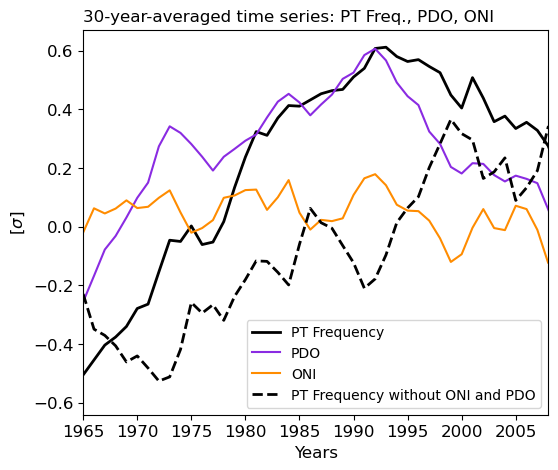

In [32]:
plt.figure(figsize=(6,5))

plt.plot(yearly_freq_std.rolling(30,center=True).mean(),color='k',label='PT Frequency',lw=2)
plt.plot(pdo.loc['1948':].rolling(30,center=True).mean(),color='blueviolet',label='PDO')
plt.plot(oni.loc['1948':].rolling(30,center=True).mean(),color='darkorange',label='ONI')
plt.plot(diff.loc['1948':].rolling(30,center=True).mean(),color='black',label='PT Frequency without ONI and PDO',ls='--',lw=2)
# plt.plot(meanghgcesm2.loc['1948':],color='green',label='PT Frequency CESM-SF GHG',ls='--')
# plt.plot(diffcesm2.loc['1948':],color='salmon',label='PT Frequency CESM-SF GHG+AER',ls='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('$[\sigma]$',fontsize=12)
plt.xlabel('Years',fontsize=12)
plt.xlim(1965,2008)
# plt.ylim(-1.5,1.5)
# plt.legend(bbox_to_anchor=(1, 1.), loc='upper left', borderaxespad=0.4)
plt.legend()
plt.title('30-year-averaged time series: PT Freq., PDO, ONI',loc='left')
# plt.savefig('../ScriptsFiguresPaper/Figures/6_PDO_ONI.png')

Text(0.0, 1.0, '30-year-averaged time series: PT Freq., PDO, ONI')

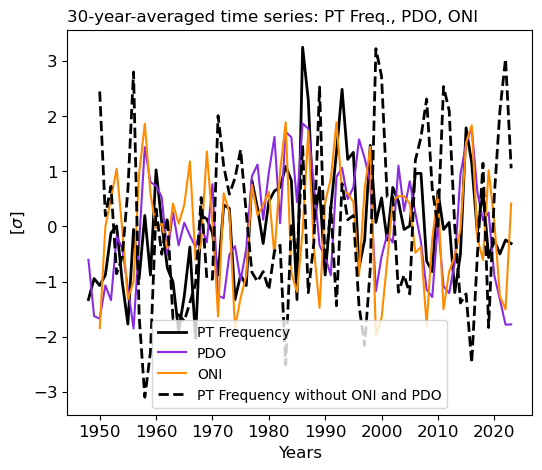

In [33]:
plt.figure(figsize=(6,5))

plt.plot(yearly_freq_std,color='k',label='PT Frequency',lw=2)
plt.plot(pdo.loc['1948':],color='blueviolet',label='PDO')
plt.plot(oni.loc['1948':],color='darkorange',label='ONI')
plt.plot(diff.loc['1948':],color='black',label='PT Frequency without ONI and PDO',ls='--',lw=2)
# plt.plot(meanghgcesm2.loc['1948':],color='green',label='PT Frequency CESM-SF GHG',ls='--')
# plt.plot(diffcesm2.loc['1948':],color='salmon',label='PT Frequency CESM-SF GHG+AER',ls='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('$[\sigma]$',fontsize=12)
plt.xlabel('Years',fontsize=12)
# plt.xlim(1965,2008)
# plt.ylim(-1.5,1.5)
# plt.legend(bbox_to_anchor=(1, 1.), loc='upper left', borderaxespad=0.4)
plt.legend()
plt.title('30-year-averaged time series: PT Freq., PDO, ONI',loc='left')

In [34]:
diff_wunits = diff*np.std(yearly_freq) + np.mean(yearly_freq)

In [35]:
def bootstrap_trend_confidence_intervals(series, n_bootstrap=1000, confidence_level=0.95):
    """
    Calculates the linear trend and confidence intervals using bootstrapping.

    Args:
        series (pd.Series): The Pandas time series.
        n_bootstrap (int): Number of bootstrap samples.
        confidence_level (float): Confidence level for the intervals.

    Returns:
        dict: A dictionary containing the trend, lower confidence interval, and upper confidence interval.
    """

    years = series.index.values
    values = series.values

    trends = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(len(years), size=len(years), replace=True)
        years_resampled = years[indices]
        values_resampled = values[indices]

        # Calculate trend
        slope, _, _, _, _ = stats.linregress(years_resampled, values_resampled)
        trends.append(slope)

    # Calculate confidence intervals
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100

    lower_ci = np.percentile(trends, lower_percentile)
    upper_ci = np.percentile(trends, upper_percentile)

    # Calculate the trend on the original data.
    original_slope, _, _, _, _ = stats.linregress(years, values)

    return {
        'trend': original_slope*10,
        'lower_ci': lower_ci*10,
        'upper_ci': upper_ci*10
    }

In [36]:
bootstrap_trend_confidence_intervals(diff_wunits.rolling(30,center=True).mean().dropna().dropna())

{'trend': 1.5679299452291895,
 'lower_ci': 1.3459273009682249,
 'upper_ci': 1.798005731934163}

In [37]:
bootstrap_trend_confidence_intervals(diff_wunits.dropna().dropna())

{'trend': 1.1300676790706503,
 'lower_ci': -0.3843193444452681,
 'upper_ci': 2.5656038012401163}

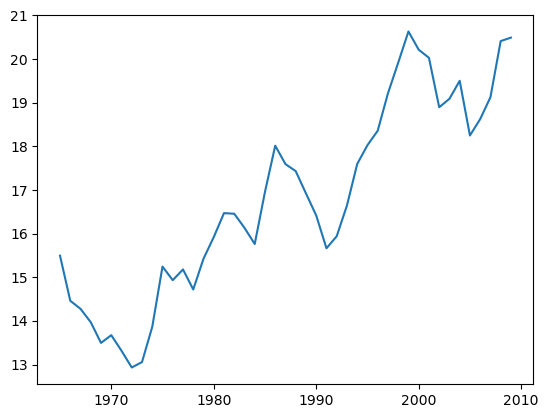

In [38]:
plt.plot(diff_wunits.rolling(30,center=True).mean().dropna())

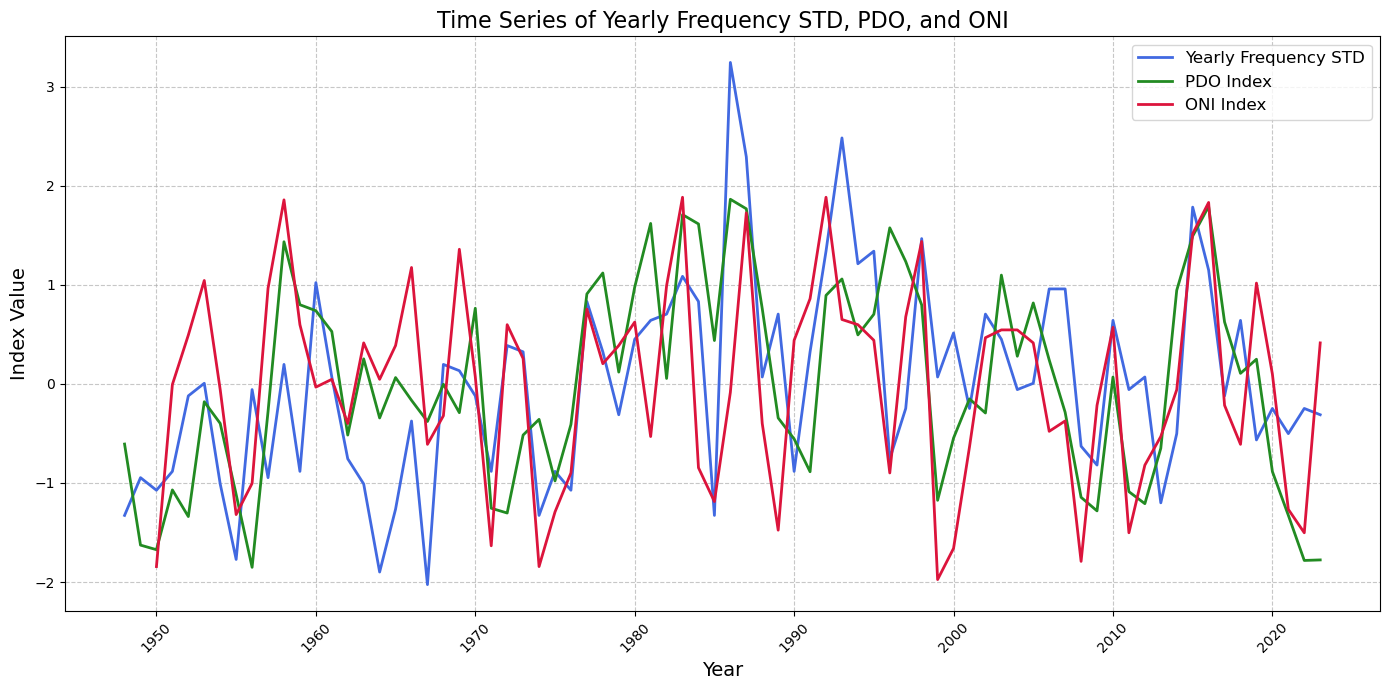

In [39]:
# Create the plot
plt.figure(figsize=(14, 7))  # Adjust figure size for better readability

# Plot the data with labels and colors
plt.plot(yearly_freq_std, label='Yearly Frequency STD', color='royalblue', linewidth=2)
plt.plot(pdo.loc['1948':], label='PDO Index', color='forestgreen', linewidth=2)
plt.plot(oni.loc['1948':], label='ONI Index', color='crimson', linewidth=2)

# Add title and axis labels
plt.title('Time Series of Yearly Frequency STD, PDO, and ONI', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Index Value', fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Improve appearance
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels


In [40]:
np.corrcoef(yearly_freq_std,pdo.loc['1948':'2023'])

array([[1.        , 0.53737035],
       [0.53737035, 1.        ]])

In [41]:
np.corrcoef(yearly_freq_std.loc['1948':'1980'],pdo.loc['1948':'1980'])

array([[1.        , 0.40965925],
       [0.40965925, 1.        ]])

In [42]:
np.corrcoef(yearly_freq_std.loc['1980':'2023'],pdo.loc['1980':'2023'])

array([[1.        , 0.53664526],
       [0.53664526, 1.        ]])

# sst

In [43]:
import xarray as xr
import pandas as pd
import numpy as np

def calculate_pixel_correlation_vectorized(data_array, time_series):
    """
    Calculates Pearson correlation between each pixel and a time series (vectorized).

    Args:
        data_array (xr.DataArray): DataArray with 'year', 'lat', and 'lon' dimensions.
        time_series (pd.Series): Pandas Series with the same index as the 'year' coordinate.

    Returns:
        xr.Dataset: Dataset with correlation coefficients and p-values.
    """

    # Ensure time_series index matches data_array year coordinate
    time_series = time_series.reindex(data_array['year'].values)

    # Calculate means and standard deviations
    data_mean = data_array.mean(dim='year')
    time_mean = time_series.mean()
    data_std = data_array.std(dim='year')
    time_std = time_series.std()

    # Calculate covariance (corrected broadcasting)
    time_series_expanded = time_series.values[:, np.newaxis, np.newaxis] # add 2 new dimensions
    covariance = np.nanmean(((data_array - data_mean).values * (time_series_expanded - time_mean)),axis=0)#.mean(axis=0)
    # 
    # # # Calculate correlation coefficients
    correlation_coeffs = covariance / (data_std.values * time_std)

    correlation_coeffs = xr.DataArray(
        correlation_coeffs,
        coords=data_mean.coords,
        dims=data_mean.dims
    )
    # Calculate t-statistic and p-values
    n = data_array.sizes['year']
    t_statistic = correlation_coeffs * np.sqrt((n - 2) / (1 - correlation_coeffs**2))
    p_values = xr.DataArray(
        2 * (1 - xr.DataArray(np.abs(t_statistic))),
        coords=data_mean.coords,
        dims=data_mean.dims
    )

    return xr.Dataset({'correlation': correlation_coeffs, 'p_value': p_values})

In [44]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]#[df_test_season['WR']==wr]
df_test_season = df_test.loc[(df_test.index.month>=12)|(df_test.index.month<=5)]

# read ssts

In [45]:
yearly_freq=yearly_freq.loc[1948:2019]

In [46]:
sst = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4WRsClimateChange/SST/sst.mnmean.nc')
#ERSSTv5

In [47]:
sst = sst.sel(time=sst['time'].dt.month.isin([12,1,2,3,4,5]))
sst = sst.sel(time=slice('1948','2019'))

In [48]:
def standardize_by_month(data_array,data_clima):
    """
    Standardizes an xarray DataArray by subtracting the multi-year monthly mean and dividing by the multi-year monthly standard deviation.

    Args:
        data_array (xr.DataArray): The input DataArray with a 'time' coordinate.

    Returns:
        xr.DataArray: The standardized DataArray.
    """

    monthly_mean = data_clima.groupby("time.month").mean("time")
    monthly_std = data_clima.groupby("time.month").std("time")

    standardized_data = data_array.groupby("time.month")
    standardized_data = standardized_data.apply(lambda x: (x - monthly_mean.sel(month=x["time.month"])) / monthly_std.sel(month=x["time.month"]))

    return standardized_data

In [85]:
sst_anoms = standardize_by_month(sst.sst,sst.sst)

In [86]:
sst_yearly = sst_anoms.groupby('time.year').mean('time')
sst_yearly = sst_yearly.sel(year=yearly_freq.index)

In [87]:
correlation_dataset = calculate_pixel_correlation_vectorized(sst_yearly, yearly_freq)
arr_temp = correlation_dataset.correlation.values
arr_temp[correlation_dataset.p_value.values>=0.05] = np.nan
correlation_dataset.correlation.data = arr_temp

/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/1160873315.py:28: RuntimeWarning: Mean of empty slice
  covariance = np.nanmean(((data_array - data_mean).values * (time_series_expanded - time_mean)),axis=0)#.mean(axis=0)
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/1160873315.py:31: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)


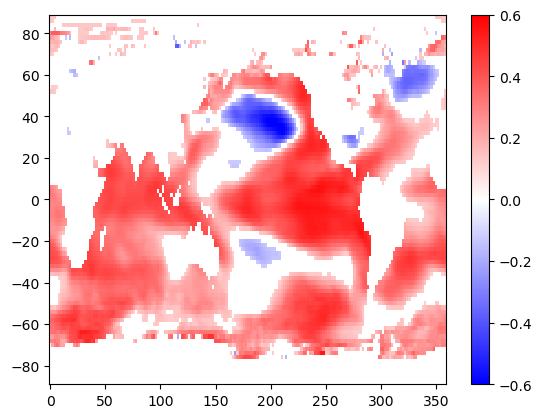

In [88]:
plt.pcolormesh(correlation_dataset.lon,correlation_dataset.lat,
               correlation_dataset.correlation,vmin=-0.6,vmax=0.6,cmap='bwr')
plt.colorbar()

In [89]:
correlation_dataset.to_netcdf('correlations_obs/corr_sst_v2.nc')

In [60]:
# from scipy import stats

# def calculate_linear_trend(data_array):
#     """
#     Calculates the pixel-by-pixel linear trend for an xarray DataArray.

#     Args:
#         data_array (xr.DataArray): The input DataArray with a 'year' coordinate.

#     Returns:
#         xr.DataArray: A DataArray containing the linear trend slopes.
#     """

#     years = data_array['year'].values
#     slopes = np.apply_along_axis(lambda y: stats.linregress(years, y).slope, axis=0, arr=data_array.values)

#     trend_da = xr.DataArray(
#         slopes,
#         coords={'lat': data_array['lat'], 'lon': data_array['lon']},
#         dims=['lat', 'lon']
#     )

#     return trend_da

import numpy as np
import xarray as xr
from scipy.stats import linregress
from numba import njit

@njit
def mann_kendall_test(y, alpha=0.05):
    n = y.size
    s = 0

    # Compute S
    for k in range(n - 1):
        for j in range(k + 1, n):
            if not np.isnan(y[k]) and not np.isnan(y[j]):
                diff = y[j] - y[k]
                if diff > 0:
                    s += 1
                elif diff < 0:
                    s -= 1

    # Effective n (non-NaN values)
    clean = ~np.isnan(y)
    y_clean = y[clean]
    n_eff = y_clean.size
    if n_eff < 2:
        return False  # Not enough data

    # Approximate variance without tie correction (safe fallback)
    var_s = n_eff * (n_eff - 1) * (2 * n_eff + 5) / 18.0
    if var_s == 0:
        return False

    z = s / np.sqrt(var_s)
    z_alpha = 1.96  # Two-tailed test for alpha=0.05

    return np.abs(z) > z_alpha

@njit
def compute_slope_if_significant(y, years, alpha=0.05):
    if np.all(np.isnan(y)):
        return np.nan

    if mann_kendall_test(y, alpha):
        mask = ~np.isnan(y)
        x = years[mask]
        y_clean = y[mask]
        if x.size < 2:
            return np.nan

        # Linear regression manually (Numba-compatible)
        x_mean = np.mean(x)
        y_mean = np.mean(y_clean)
        num = np.sum((x - x_mean) * (y_clean - y_mean))
        den = np.sum((x - x_mean) ** 2)
        if den == 0:
            return np.nan
        return num / den
    else:
        return np.nan


def calculate_trend_vectorized_mk(data_array, alpha=0.05):
    years = data_array['year'].values
    data = data_array.values  # shape: (time, lat, lon)
    time_len, nlat, nlon = data.shape

    slopes = np.full((nlat, nlon), np.nan)

    for i in range(nlat):
        for j in range(nlon):
            y = data[:, i, j]
            slopes[i, j] = compute_slope_if_significant(y, years, alpha)

    return xr.DataArray(slopes, coords={'lat': data_array['lat'], 'lon': data_array['lon']}, dims=['lat', 'lon'])


In [75]:
sst_trends = calculate_trend_vectorized_mk(sst_yearly.sel(year=slice(1948,1990)))
sst_trends.to_netcdf(f'trends_obs/trend_sst_back_v3.nc')

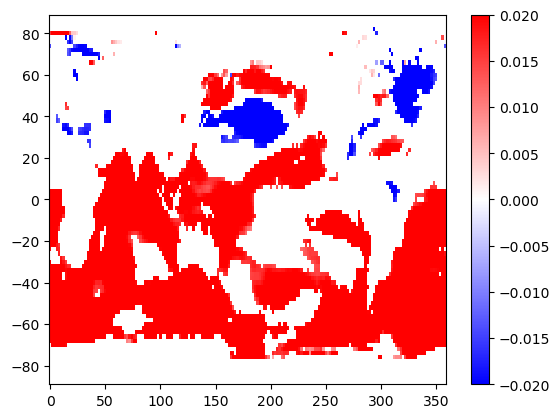

In [76]:
plt.pcolormesh(sst_trends.lon,sst_trends.lat,
               sst_trends,vmin=-0.02,vmax=0.02,cmap='bwr')
plt.colorbar()

In [77]:
sst_trends = calculate_trend_vectorized_mk(sst_yearly.sel(year=slice(1990,2019)))
sst_trends.to_netcdf(f'trends_obs/trend_sst_recent_v3.nc')

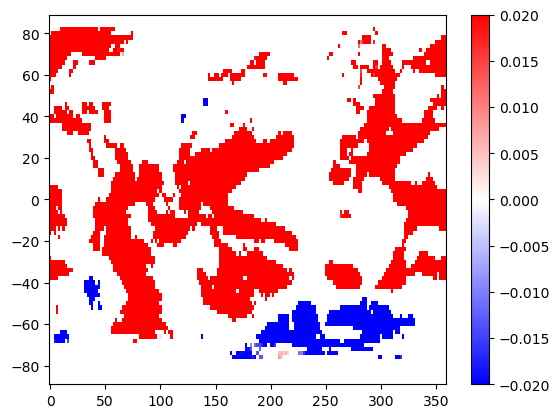

In [78]:
plt.pcolormesh(sst_trends.lon,sst_trends.lat,
               sst_trends,vmin=-0.02,vmax=0.02,cmap='bwr')
plt.colorbar()

# AOD

In [79]:
def standardize_by_month(data_array,data_clima):
    """
    Standardizes an xarray DataArray by subtracting the multi-year monthly mean and dividing by the multi-year monthly standard deviation.

    Args:
        data_array (xr.DataArray): The input DataArray with a 'time' coordinate.

    Returns:
        xr.DataArray: The standardized DataArray.
    """

    monthly_mean = data_clima.groupby("time.month").mean("time")
    monthly_std = data_clima.groupby("time.month").std("time")

    standardized_data = data_array.groupby("time.month")
    standardized_data = standardized_data.apply(lambda x: (x - monthly_mean.sel(month=x["time.month"])) / monthly_std.sel(month=x["time.month"]))

    return standardized_data

In [80]:
def shift_longitude_to_0_360(dataset):
    """
    Shifts the longitudes of an xarray Dataset from [-180, 180] to [0, 360].

    Args:
        dataset (xr.Dataset): The input Dataset with 'lon' coordinates.

    Returns:
        xr.Dataset: The Dataset with shifted longitudes.
    """

    # Identify negative longitudes
    negative_lons = dataset['lon'].values < 0

    # Shift negative longitudes
    shifted_lons = dataset['lon'].values.copy()
    shifted_lons[negative_lons] += 360

    # Reassign coordinates
    shifted_dataset = dataset.assign_coords(lon=shifted_lons)

    # Reorder (optional, if needed)
    shifted_dataset = shifted_dataset.sortby('lon')

    return shifted_dataset

In [81]:
path_files = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/AOD/'

In [82]:
files_aod = np.sort(glob.glob(f'{path_files}*.nc4'))

In [83]:
xr.open_dataset(files_aod[0])

<xarray.Dataset> Size: 83MB
Dimensions:        (lon: 576, lat: 361, time: 1)
Coordinates:
  * lon            (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * lat            (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * time           (time) datetime64[ns] 8B 1980-01-01T00:30:00
Data variables: (12/100)
    BCANGSTR       (time, lat, lon) float32 832kB ...
    BCCMASS        (time, lat, lon) float32 832kB ...
    BCEXTTAU       (time, lat, lon) float32 832kB ...
    BCFLUXU        (time, lat, lon) float32 832kB ...
    BCFLUXV        (time, lat, lon) float32 832kB ...
    BCSCATAU       (time, lat, lon) float32 832kB ...
    ...             ...
    Var_SUFLUXU    (time, lat, lon) float32 832kB ...
    Var_SUFLUXV    (time, lat, lon) float32 832kB ...
    Var_SUSCATAU   (time, lat, lon) float32 832kB ...
    Var_TOTANGSTR  (time, lat, lon) float32 832kB ...
    Var_TOTEXTTAU  (time, lat, lon) float32 832kB ...
    Var_TOTSCATAU  (time, lat, lon) float32 832kB ...
Attributes: (12/30)
    History:                           Original file generated: Thu May  7 21...
    Filename:                          MERRA2_100.tavgM_2d_aer_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/FH9A0MLJPC7N
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

In [84]:
names_vars = ['BCEXTTAU','DUEXTT25','DUEXTTAU','OCEXTTAU','SSEXTT25','SSEXTTAU','SUEXTTAU','TOTEXTTAU']

In [73]:
aod_full = []
for file in files_aod:
    aod_full.append(xr.open_dataset(file)[names_vars])

# https://disc.gsfc.nasa.gov/datasets/M2TMNXAER_5.12.4/summary
aod_full = xr.concat(aod_full,dim='time')

aod_full = aod_full.sortby('time')
aod_full = aod_full.sel(time=aod_full['time'].dt.month.isin([12,1,2,3,4,5]))
aod_full = aod_full.resample(time='MS').mean()

In [74]:
for namevar in names_vars:
    aod = aod_full[namevar]
    aod_anoms = standardize_by_month(aod,aod)
    
    aod_anoms_yearly = aod_anoms.groupby('time.year').mean('time')
    aod_anoms_yearly = aod_anoms_yearly.sel(year=yearly_freq.index[32:])
    
    correlation_dataset = calculate_pixel_correlation_vectorized(aod_anoms_yearly, yearly_freq.iloc[32:])
    arr_temp = correlation_dataset.correlation.values
    arr_temp[correlation_dataset.p_value.values>=0.05] = np.nan
    correlation_dataset.correlation.data = arr_temp
    correlation_dataset.to_netcdf(f'correlations_obs/corr_aod_{namevar}_v3.nc')
    
    correlation_dataset = shift_longitude_to_0_360(correlation_dataset)
    aod_trends = calculate_trend_vectorized_mk(aod_anoms_yearly)
    aod_trends.to_netcdf(f'trends_obs/trend_aod_{namevar}_v3.nc')
    # fontsize_most_things=12
    # fontsize=fontsize_most_things
    # ##### Plot ####
    # fig, axs = plt.subplots(1, 1,figsize=(7,4), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
    
    # ax_temp = axs
    # intervals = 41
    # mini=-0.6
    # maxi=0.6
    # bounds=np.linspace(mini,maxi,intervals)
    # # print(vmax,vmin)
    # pm = ax_temp.pcolormesh(correlation_dataset.lon,correlation_dataset.lat,\
    #     correlation_dataset.correlation,cmap='bwr',
    #     transform=ccrs.PlateCarree(),
    #     vmin=mini,vmax=maxi)
    # ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    # # ax_temp.margins(x=0, y=0)
    # # Add colorbar
    # cbar_ax = fig.add_axes([0.4, 0.035, 0.15, 0.01])
    # ticks_1 = [-0.6,0,0.6]
    # cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
    #                 orientation='horizontal', extend='both')
    # cbar.ax.tick_params(labelsize=fontsize_most_things)
    # cbar.set_label('Correlation', fontsize=fontsize_most_things)
    # # Set geographical extent (lon_min, lon_max, lat_min, lat_max)
    
    # ax_temp.set_title(f'{namevar} Correlation with PT frequency: Observations',loc='left',fontsize=fontsize)
    
    # plt.tight_layout()
    # plt.savefig(f'Figures/AOD_Corr_{namevar}.png',bbox_inches='tight')
    # plt.close('all')


    fontsize_most_things=12
    fontsize=fontsize_most_things
    ##### Plot ####
    fig, axs = plt.subplots(1, 1,figsize=(7,4), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
    
    ax_temp = axs
    intervals = 41
    maxi = np.round(abs(aod_trends).quantile(0.95),3)
    mini = -np.round(abs(aod_trends).quantile(0.95),3)
    
    bounds=np.linspace(mini,maxi,intervals)
    # print(vmax,vmin)
    pm = ax_temp.pcolormesh(aod_trends.lon,aod_trends.lat,\
        aod_trends,cmap='bwr',
        transform=ccrs.PlateCarree(),
        vmin=mini,vmax=maxi)
    ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    # ax_temp.margins(x=0, y=0)
    # Add colorbar
    cbar_ax = fig.add_axes([0.4, 0.035, 0.15, 0.01])
    ticks_1 = [mini,0,maxi]
    cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')
    cbar.ax.tick_params(labelsize=fontsize_most_things)
    cbar.set_label('Correlation', fontsize=fontsize_most_things)
    # Set geographical extent (lon_min, lon_max, lat_min, lat_max)
    
    ax_temp.set_title(f'{namevar} Correlation with PT frequency: Observations',loc='left',fontsize=fontsize)
    
    plt.tight_layout()
    plt.savefig(f'Figures/AOD_Trend_{namevar}_v3.png',bbox_inches='tight')
    plt.close('all')


/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2576120408.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2576120408.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2576120408.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2576120408.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/derecho/scratch/jhayron/tmp/ipykernel_91959/2576120408.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.

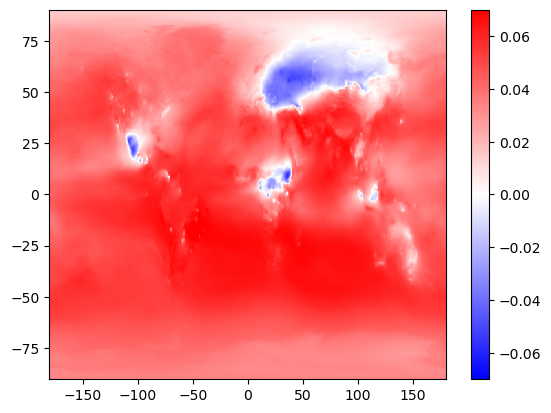

In [40]:
plt.pcolormesh(aod_trends.lon,aod_trends.lat,
               aod_trends,vmin=-0.07,vmax=0.07,cmap='bwr')
plt.colorbar()

<xarray.DataArray ()> Size: 8B
array(0.065)
Coordinates:
    quantile  float64 8B 0.95

In [42]:
correlation_dataset.to_netcdf('correlations_obs/corr_aod.nc')

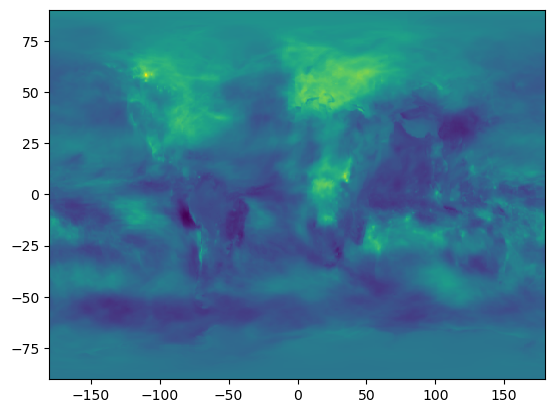

In [43]:
plt.pcolormesh(aod_anoms_yearly.lon,aod_anoms_yearly.lat,aod_anoms_yearly[0])

In [44]:
from scipy import stats

def calculate_linear_trend(data_array):
    """
    Calculates the pixel-by-pixel linear trend for an xarray DataArray.

    Args:
        data_array (xr.DataArray): The input DataArray with a 'year' coordinate.

    Returns:
        xr.DataArray: A DataArray containing the linear trend slopes.
    """

    years = data_array['year'].values
    slopes = np.apply_along_axis(lambda y: stats.linregress(years, y).slope, axis=0, arr=data_array.values)

    trend_da = xr.DataArray(
        slopes,
        coords={'lat': data_array['lat'], 'lon': data_array['lon']},
        dims=['lat', 'lon']
    )

    return trend_da

In [45]:
aod_trends = calculate_linear_trend(aod_anoms_yearly)

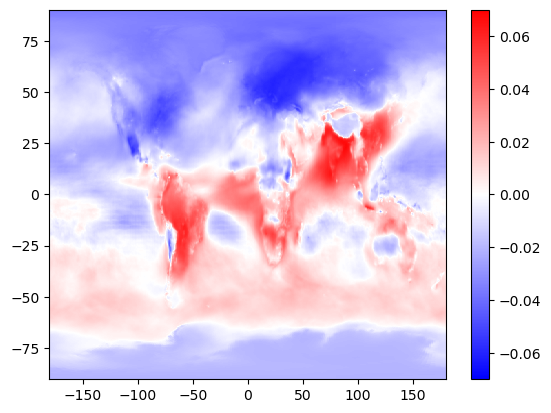

In [46]:
plt.pcolormesh(aod_trends.lon,aod_trends.lat,
               aod_trends,vmin=-0.07,vmax=0.07,cmap='bwr')
plt.colorbar()

In [47]:
def remove_linear_trend(data_array):
    """
    Removes the pixel-by-pixel linear trend from an xarray DataArray.

    Args:
        data_array (xr.DataArray): The input DataArray with a 'year' coordinate.

    Returns:
        xr.DataArray: A DataArray with the linear trend removed.
    """

    years = data_array['year'].values
    detrended_data = np.apply_along_axis(lambda y: detrend_pixel(years, y), axis=0, arr=data_array.values)

    detrended_da = xr.DataArray(
        detrended_data,
        coords={'year': data_array['year'], 'lat': data_array['lat'], 'lon': data_array['lon']},
        dims=['year', 'lat', 'lon']
    )

    return detrended_da

def detrend_pixel(years, pixel_values):
    """
    Removes the linear trend from a single pixel's time series.

    Args:
        years (np.ndarray): The array of years.
        pixel_values (np.ndarray): The time series of pixel values.

    Returns:
        np.ndarray: The detrended time series.
    """
    slope, intercept, _, _, _ = stats.linregress(years, pixel_values)
    trend = slope * years + intercept
    detrended_values = pixel_values - trend
    return detrended_values

In [48]:
aod_anoms_yearly_detrended = remove_linear_trend(aod_anoms_yearly)

In [49]:
correlation_dataset = calculate_pixel_correlation_vectorized(aod_anoms_yearly_detrended, 
                                                             yearly_freq.iloc[32:])
arr_temp = correlation_dataset.correlation.values
arr_temp[correlation_dataset.p_value.values>=0.05] = np.nan
correlation_dataset.correlation.data = arr_temp

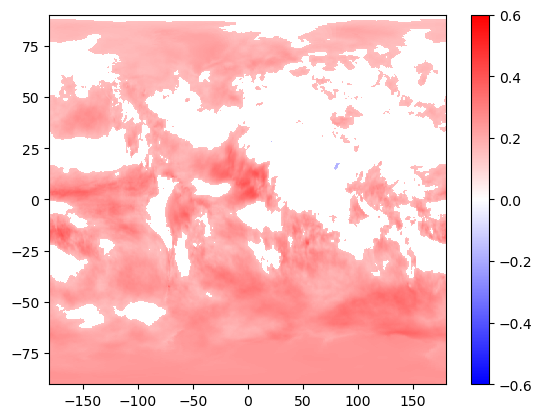

In [50]:
plt.pcolormesh(correlation_dataset.lon,correlation_dataset.lat,
               correlation_dataset.correlation,vmin=-0.6,vmax=0.6,cmap='bwr')
plt.colorbar()

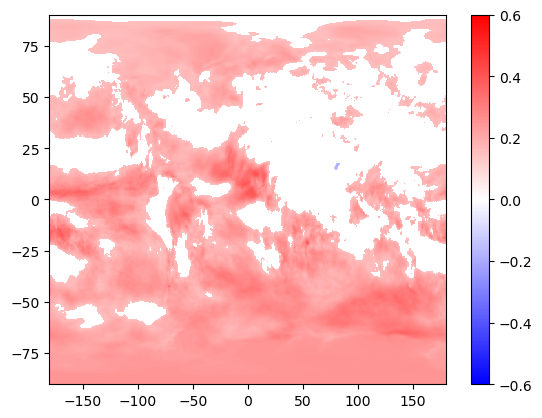

In [164]:
plt.pcolormesh(correlation_dataset.lon,correlation_dataset.lat,
               correlation_dataset.correlation,vmin=-0.6,vmax=0.6,cmap='bwr')
plt.colorbar()

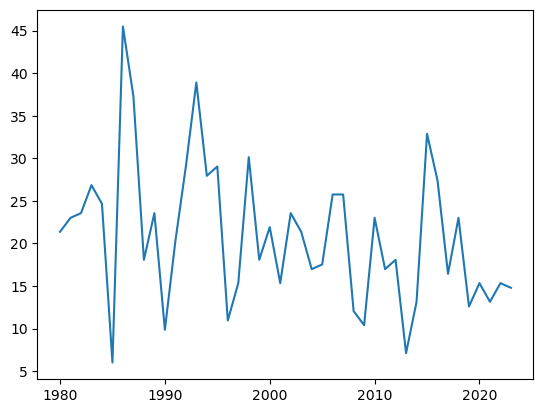

In [156]:
plt.plot(yearly_freq.iloc[32:])